# Практика по базовой математической статистике для Data scientist

# Практика 1 - анализ распределения случайной величины

- Генерация распределений - делаем синтетический датасет по заданным параметрам распределений (пара вариантов из непрерывных функций)
- Построение гистограммы распределения при помощи mathplotlib / seaborn.
- Анализ основных метрик распределения с помощью pandas и numpy - учимся делать выводы по оценкам случайной величины и форме распределения.

Для начала импортируем все полезные библитеки и настроим ноутбук

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special as sps
import warnings
from scipy.stats import kurtosis
from scipy.stats import skew

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 7.0)
warnings.filterwarnings("ignore")

Пусть у нас будут два датасета - прибыль по клиентам разных групп, распределенные по нормальному закону N(500,1000) и Гамма закону, параметры которого будет необходимо вычислить на основе средней прибыли = 500 и среднеквадратическому отклонению = 1000.

Сгенерируем синтетические выборки размера ns = 10000 клиентов каждая.

In [2]:
ns = 10000
n_mean = 500
n_sigma = 1000

## Работаем с симметричным распределением

Используем имитацию нормального распределения отсюда
https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.normal.html

In [3]:
v = np.random.normal(n_mean, n_sigma, ns)
v = pd.DataFrame(v,columns = ["volume"])
v.volume = round(v.volume,0)

In [4]:
v.head()

,volume
0,13.0
1,875.0
2,2389.0
3,851.0
4,-641.0


Для оценки среднего, среднеквадратического отклонения и квантилей можно воспользоваться отдельными методами pandas и numpy

In [5]:
# Среднее
v.volume.mean()

492.5569

In [6]:
# Медиана
v.volume.median()

493.0

In [7]:
# Мода
v.volume.value_counts().nlargest(10)

 35.0     11
 593.0    11
 188.0    10
-380.0    10
 958.0    10
 463.0    10
 441.0    10
 866.0    10
 522.0    10
 113.0    10
Name: volume, dtype: int64

In [8]:
# Среднеквадратическое отклонение - далее ско
v.volume.std()

997.8500903656179

In [9]:
#  Квантиль - медиана
np.percentile(v.volume, 50)

493.0

In [10]:
# Кванталь - 0.75
np.percentile(v.volume, 75)

1167.0

Однако, удобнее воспользоваться встроенные методом pandas describe()

In [11]:
v.volume.describe()

count    10000.00000
mean       492.55690
std        997.85009
min      -3895.00000
25%       -183.25000
50%        493.00000
75%       1167.00000
max       4133.00000
Name: volume, dtype: float64

Здесь мы видим как среднее значение, так максимум, минимум, ско и все полезные квантили.

Теперь построим гистограмму распределения - сделаем это двумя способами, при помощи seaborn и встроенного метода pandas hist()

Text(0.5, 1.0, 'Распределение прибыли по пользователям группы 1')

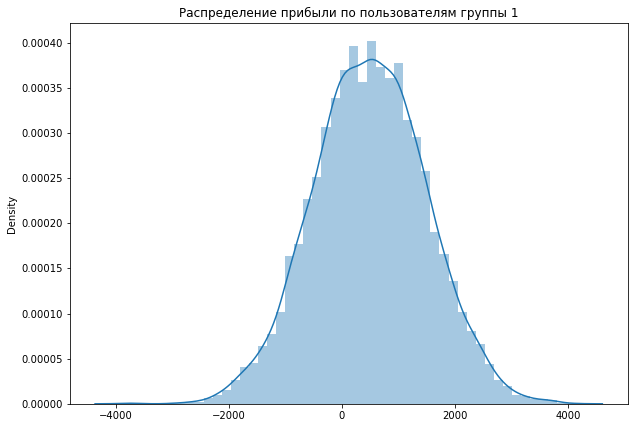

In [12]:
# При помощи seaborn
sns.distplot(v)
plt.title("Распределение прибыли по пользователям группы 1")

Text(0.5, 1.0, 'Распределение прибыли по пользователям группы 1')

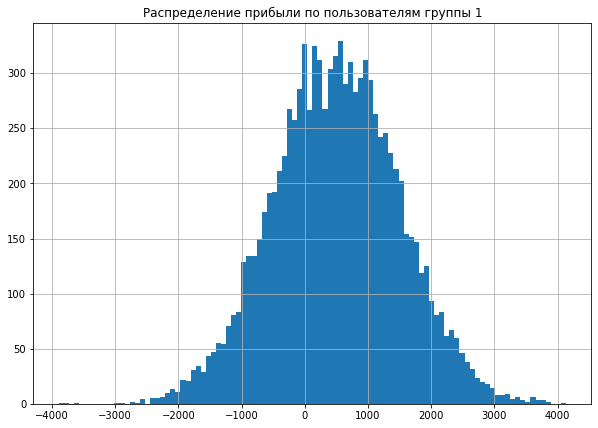

In [13]:
# При помощи pandas
v.volume.hist(bins = 100)
plt.title("Распределение прибыли по пользователям группы 1")

И не забудем про коэффициенты эксцесса и ассиметрии

In [14]:
# Эксцесс
kurtosis(v.volume)

0.01277066557996731

In [15]:
# Ассиметрия
skew(v.volume)

-0.003367430240359747

Теперь объединим все в одну функцию для удобства работы со вторй выборкой

In [16]:
def my_basic_research(df=v, column = "volume"):
    print("Базовые метрики")
    print(df[column].describe())
    print("------------------------------------")
    
    print("Самые популярные значения метрики, топ 5")
    print(df[column].value_counts().nlargest(5))
    print("------------------------------------")
    
    print("Эксцесс ", kurtosis(df[column]))
    print("Ассиметрия ", skew(df[column]))
    
    sns.distplot(df[column])
    plt.title("Распределение прибыли по пользователям")

Базовые метрики
count    10000.00000
mean       492.55690
std        997.85009
min      -3895.00000
25%       -183.25000
50%        493.00000
75%       1167.00000
max       4133.00000
Name: volume, dtype: float64
------------------------------------
Самые популярные значения метрики, топ 5
 35.0     11
 593.0    11
 188.0    10
-380.0    10
 958.0    10
Name: volume, dtype: int64
------------------------------------
Эксцесс  0.01277066557996731
Ассиметрия  -0.003367430240359747


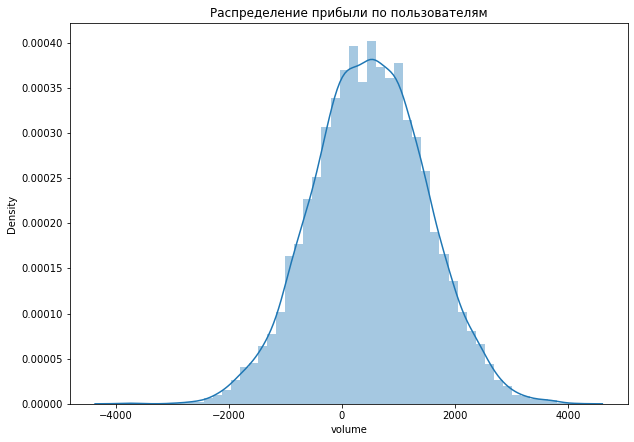

In [17]:
# Опробуем нашу функцию.
my_basic_research()

## Проверим на ассиметричном распределении

Вот так выглядит случай симметричных данных. Но в мире не все распределения симметричны - поэтому попробуем выяснить, чем это нам грозит, повторив анализ для Гамма распределения. Для начала подготовим датасет.

Параметры Гамма закона k и theta связаны со средним и дисперсией этого закона следующим образом (https://ru.wikipedia.org/wiki/Гамма-распределение):

$$m(x)=k*theta$$
$$D(x)=k*theta^2$$

Решая как систему уравнений, получим:

$$ k=(m(x)^2)/D(x)$$
$$theta=D(x)/m(x)$$

Зададим функцию для поиска параметров Гамма распределения по среднему и СКО

In [18]:
def gamma_params(mean, std):
    shape = round((mean/std)**2, 4)
    scale = round((std**2)/mean, 4)
    return (shape, scale)

In [19]:
shape, scale = gamma_params(n_mean, n_sigma)
df = np.random.gamma(shape, scale, ns)
df = pd.DataFrame(df,columns = ["volume"])

# Округлим до целых
df.volume = round(df.volume,0)

In [20]:
df.head()

,volume
0,308.0
1,5.0
2,7.0
3,12.0
4,7.0


Базовые метрики
count    10000.000000
mean       509.245900
std        989.840269
min          0.000000
25%          6.000000
50%         92.000000
75%        560.000000
max      14697.000000
Name: volume, dtype: float64
------------------------------------
Самые популярные значения метрики, топ 5
0.0    1342
1.0     405
2.0     279
3.0     165
4.0     162
Name: volume, dtype: int64
------------------------------------
Эксцесс  23.64709069151734
Ассиметрия  3.911293840045612


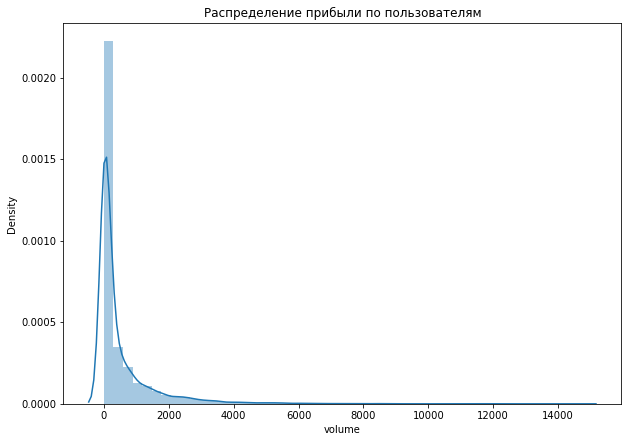

In [21]:
my_basic_research(df = df, column = "volume")

Как можно увидеть, теперь мы имеем дело а ассиметричным распределением и все квантили, а такде коэффициенты ассиметрии и эксцесса поменялись, несмотря на равенство средних и ско - и выводы по этим датасетам получаются абсолютно разные.

К примеру, сравним долю убыточных клиентов для первого и второго датасетов:

In [22]:
v[v.volume < 0].count()/len(v)

volume    0.316
dtype: float64

In [23]:
df[df.volume < 0].count()/len(df)

volume    0.0
dtype: float64

А теперь сравним суммарную прибыль по клиентам с прибылью свыше медианы в млн:

In [24]:
v[v.volume >= np.percentile(v.volume,50)].volume.sum()/10**6

6.458368

In [25]:
df[df.volume >= np.percentile(df.volume,50)].volume.sum()/10**6

5.002377

Как можно видеть, эффект от ассимерии при одинаковых средних и ско существенно менять выводы.

## Мини домашка

Найдите медиану для Гамма распределения со средним = 1000 и среднеквадратичным отклонением = 3000, не округляя значения синтетического датасета.
Какое число получилось?

In [26]:
shape, scale = gamma_params(1000, 3000)
df = np.random.gamma(shape, scale, ns)
df = pd.DataFrame(df,columns = ["volume"])
df.volume.median()

10.104760633474136